In [2]:
!pip install git+https://github.com/openai/CLIP.git -q

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import clip
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import random
import time

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.0 MB/s eta 0:00:00
Device: cuda


In [4]:
print("Loading CLIP Teacher...")
teacher_model, clip_preprocess = clip.load("ViT-B/32", device=device)
teacher_model.eval()

for p in teacher_model.parameters():
    p.requires_grad = False

batch_size = 64

train_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=clip_preprocess
)

test_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=clip_preprocess
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

y_test = np.concatenate([labels.numpy() for _, labels in test_loader])

print("Dataset ready.")

Loading CLIP Teacher...


100%|███████████████████████████████████████| 338M/338M [00:03<00:00, 91.6MiB/s]
100%|██████████| 170M/170M [00:01<00:00, 93.5MB/s] 


Dataset ready.


In [9]:
class ScalableStudent(nn.Module):
    def __init__(self, width_factor=1, output_dim=512):
        super().__init__()

        c1, c2, c3 = 16 * width_factor, 32 * width_factor, 64 * width_factor

        self.features = nn.Sequential(
            nn.Conv2d(3, c1, 3, padding=1),
            nn.BatchNorm2d(c1), nn.ReLU(), nn.MaxPool2d(2),

            nn.Conv2d(c1, c2, 3, padding=1),
            nn.BatchNorm2d(c2), nn.ReLU(), nn.MaxPool2d(2),

            nn.Conv2d(c2, c3, 3, padding=1),
            nn.BatchNorm2d(c3), nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))
        )

        self.projector = nn.Sequential(
            nn.Linear(c3 * 16, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.projector(x)

In [ ]:
print("--- Calculating Quantitative Summaries ---")

effective_ranks, dims_90_var, alignments = [], [], []
params_millions = [0.5, 2.0, 8.0]
log_params = np.log10(params_millions)
model_names = list(models_dict.keys())

for name in model_names:
    S = svd_results[name]
    
    cum_var = np.cumsum(S**2) / np.sum(S**2)
    dims_90_var.append(np.argmax(cum_var >= 0.90) + 1)
    
    p = S / np.sum(S)
    entropy = -np.sum(p * np.log(p + 1e-10))
    effective_ranks.append(np.exp(entropy))

print("Calculating Student-Teacher Alignment (Cosine Similarity)...")
for name, student_model in models_dict.items():
    student_model.eval()
    batch_sims = []
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            z_student = F.normalize(student_model(images), p=2, dim=-1)
            z_teacher = F.normalize(teacher_model.encode_image(images), p=2, dim=-1)
            batch_sims.append((z_student * z_teacher).sum(dim=-1).mean().item())
    alignments.append(np.mean(batch_sims))

print("\n=== QUANTITATIVE SCALING LAWS ===")
for i, name in enumerate(model_names):
    print(f"{name}:\n  - Effective Rank: {effective_ranks[i]:.2f}\n  - Dims for 90% Var: {dims_90_var[i]}\n  - Alignment: {alignments[i]:.4f}\n")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = ['red', 'orange', 'green']

for i, name in enumerate(model_names):
    S = svd_results[name]
    cum_var = np.cumsum(S**2) / np.sum(S**2)
    axes[0].plot(cum_var, label=name, color=colors[i], linewidth=2)
    axes[0].axvline(x=dims_90_var[i], color=colors[i], linestyle='--', alpha=0.5)
axes[0].axhline(y=0.90, color='black', linestyle=':', label='90% Threshold')
axes[0].set_title("Cumulative Variance Explained")
axes[0].set_xlabel("Dimensions (Rank)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(log_params, effective_ranks, marker='o', markersize=10, linestyle='-', color='purple', linewidth=2)
axes[1].set_title("Effective Rank Scaling")
axes[1].set_xlabel("Log10(Parameters in Millions)")
axes[1].set_xticks(log_params)
axes[1].set_xticklabels(['0.5M', '2.0M', '8.0M'])
axes[1].grid(True, alpha=0.3)

axes[2].plot(effective_ranks, alignments, marker='s', markersize=10, linestyle='-', color='teal', linewidth=2)
for i, name in enumerate(['S', 'M', 'L']):
    axes[2].annotate(f' {name}', (effective_ranks[i], alignments[i]), fontsize=12)
axes[2].set_title("Alignment Saturation")
axes[2].set_xlabel("Effective Rank")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Starting Multi-Seed Training

========== SEED 42 ==========

Training Model S


S Probe Accuracy: 71.08%

Training Model M


M Probe Accuracy: 72.48%

Training Model L


L Probe Accuracy: 73.21%

========== SEED 123 ==========

Training Model S


S Probe Accuracy: 70.58%

Training Model M


M Probe Accuracy: 72.84%

Training Model L


L Probe Accuracy: 72.33%

========== SEED 456 ==========

Training Model S


S Probe Accuracy: 71.66%

Training Model M


M Probe Accuracy: 71.65%

Training Model L


L Probe Accuracy: 73.28%


In [5]:
print("\nScaling Laws")

effective_ranks = []
dims_90 = []

for name in ["S","M","L"]:
    mean_s = np.mean(np.vstack(all_svd_results[name]), axis=0)
    svd_results[name] = mean_s

    variances = mean_s**2
    p = variances / np.sum(variances)

    entropy = -np.sum(p * np.log(p + 1e-10))
    effective_ranks.append(np.exp(entropy))

    dims_90.append(np.argmax(np.cumsum(p) >= 0.90) + 1)

print("Effective Rank:", dict(zip(["S","M","L"], effective_ranks)))
print("90% Variance Dims:", dict(zip(["S","M","L"], dims_90)))

print("\nLinear Probe Results:")
for k,v in all_probe_results.items():
    print(k, ":", round(np.mean(v),2), "±", round(np.std(v),2))


Scaling Laws
Effective Rank: {'S': np.float32(15.905746), 'M': np.float32(16.628271), 'L': np.float32(16.663641)}
90% Variance Dims: {'S': np.int64(19), 'M': np.int64(20), 'L': np.int64(20)}

Linear Probe Results:
S : 71.11 ± 0.44
M : 72.32 ± 0.5
L : 72.94 ± 0.43



Teacher Subspace Alignment


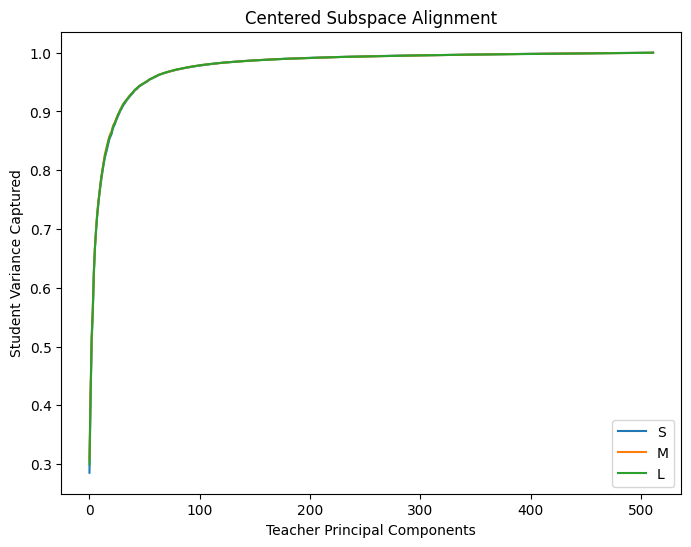

In [ ]:
print("\nTeacher Subspace Alignment")

teacher_embs = []

with torch.no_grad():
    for images, _ in test_loader:
        z = F.normalize(
            teacher_model.encode_image(images.to(device)),
            dim=-1
        )
        teacher_embs.append(z.cpu())

Z_teacher = torch.cat(teacher_embs).float()

Z_teacher_centered = Z_teacher - Z_teacher.mean(dim=0, keepdim=True)

_, _, Vh_teacher = torch.linalg.svd(
    Z_teacher_centered,
    full_matrices=False
)

plt.figure(figsize=(8,6))

for name in ["S","M","L"]:

    Z_s = student_test_embeddings_dict[name].float()

    proj_var = torch.sum((Z_s @ Vh_teacher.T)**2, dim=0)

    cum_align = (
        torch.cumsum(proj_var, dim=0) /
        torch.sum(Z_s**2)
    ).numpy()

    plt.plot(cum_align, label=name)

plt.title("Centered Subspace Alignment")
plt.xlabel("Teacher Principal Components")
plt.ylabel("Student Variance Captured")
plt.legend()
plt.show()

In [8]:
print("\nRobustness Evaluation")

g = torch.Generator()
g.manual_seed(999)

robust_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    generator=g
)

def gaussian_noise(x, s):
    return x + torch.randn_like(x) * s

noise_levels = [0, 0.02, 0.05, 0.1, 0.2]

for name, model in models_dict.items():

    print("\nModel:", name)
    model.eval()

    train_embs, train_labels = [], []

    with torch.no_grad():
        for images, labels in robust_loader:
            z = F.normalize(model(images.to(device)), dim=-1)
            train_embs.append(z.cpu().numpy())
            train_labels.append(labels.numpy())

    probe = LogisticRegression(
        max_iter=2000, solver="lbfgs", n_jobs=-1
    )

    probe.fit(np.vstack(train_embs), np.concatenate(train_labels))

    for s in noise_levels:
        preds = []

        with torch.no_grad():
            for images, _ in test_loader:
                corrupted = gaussian_noise(images, s).to(device)
                z = F.normalize(model(corrupted), dim=-1)
                preds.extend(probe.predict(z.cpu().numpy()))

        acc = accuracy_score(y_test, preds) * 100
        print("Noise", s, "→", round(acc,2))


Robustness Evaluation

Model: S
Noise 0 → 71.67
Noise 0.02 → 71.38
Noise 0.05 → 66.85
Noise 0.1 → 49.91
Noise 0.2 → 27.1

Model: M
Noise 0 → 71.6
Noise 0.02 → 71.16
Noise 0.05 → 67.98
Noise 0.1 → 55.24
Noise 0.2 → 21.25

Model: L
Noise 0 → 73.29
Noise 0.02 → 72.92
Noise 0.05 → 69.09
Noise 0.1 → 41.09
Noise 0.2 → 12.0


--- Phase 3: Information-Theoretic Evaluation ---
Calculating Mutual Information (InfoNCE) and Uniformity on Test Set...

S:
  - InfoNCE Loss (Lower is better MI): 3.3117
  - Uniformity Loss (Lower is better spread): -0.4061

M:
  - InfoNCE Loss (Lower is better MI): 3.2996
  - Uniformity Loss (Lower is better spread): -0.4153

L:
  - InfoNCE Loss (Lower is better MI): 3.2738
  - Uniformity Loss (Lower is better spread): -0.4285



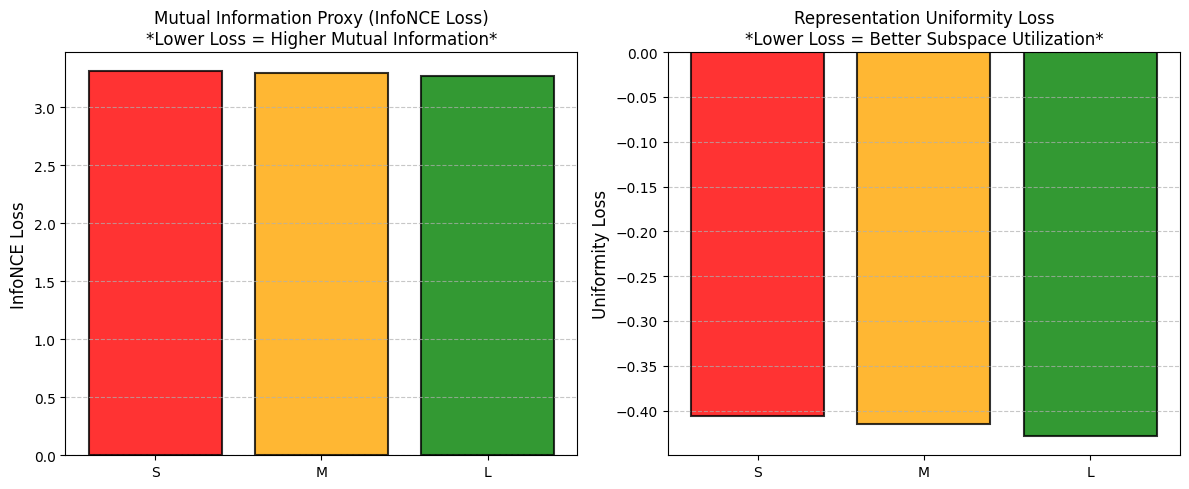

In [ ]:
print("--- Phase 3: Information-Theoretic Evaluation ---")

def calculate_infonce_and_uniformity(student_model, teacher_model, dataloader, device, temperature=0.1):
    student_model.eval()
    total_infonce = 0.0
    total_uniformity = 0.0
    num_batches = 0
    
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            
            z_s = F.normalize(student_model(images), p=2, dim=-1).to(torch.float32)
            z_t = F.normalize(teacher_model.encode_image(images), p=2, dim=-1).to(torch.float32)
            
            sim_matrix = torch.matmul(z_s, z_t.T) / temperature
            
            labels = torch.arange(z_s.size(0)).to(device)
            
            loss_infonce = F.cross_entropy(sim_matrix, labels)
            total_infonce += loss_infonce.item()
            
            sq_pdist = torch.cdist(z_s, z_s) ** 2
            uniformity = torch.log(torch.mean(torch.exp(-2.0 * sq_pdist)))
            total_uniformity += uniformity.item()
            
            num_batches += 1
            
    return total_infonce / num_batches, total_uniformity / num_batches

info_metrics = {"Student-S (~0.5M)": {}, "Student-M (~2.0M)": {}, "Student-L (~8.0M)": {}}

print("Calculating Mutual Information (InfoNCE) and Uniformity on Test Set...\n")

for model_name, student_model in models_dict.items():
    infonce, uniformity = calculate_infonce_and_uniformity(
        student_model, teacher_model, test_loader, device
    )
    
    info_metrics[model_name] = {"InfoNCE": infonce, "Uniformity": uniformity}
    
    print(f"{model_name}:")
    print(f"  - InfoNCE Loss (Lower is better MI): {infonce:.4f}")
    print(f"  - Uniformity Loss (Lower is better spread): {uniformity:.4f}\n")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
colors = ['red', 'orange', 'green']
names = list(models_dict.keys())

infonce_vals = [info_metrics[n]["InfoNCE"] for n in names]
uniformity_vals = [info_metrics[n]["Uniformity"] for n in names]

# Panel A: InfoNCE
axes[0].bar(names, infonce_vals, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0].set_title("Mutual Information Proxy (InfoNCE Loss)\n*Lower Loss = Higher Mutual Information*", fontsize=12)
axes[0].set_ylabel("InfoNCE Loss", fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Panel B: Uniformity
axes[1].bar(names, uniformity_vals, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1].set_title("Representation Uniformity Loss\n*Lower Loss = Better Subspace Utilization*", fontsize=12)
axes[1].set_ylabel("Uniformity Loss", fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
print("Extracting Teacher Spectral Stats...")
with torch.no_grad():
    t_embs = [F.normalize(teacher_model.encode_image(img.to(device)), p=2, dim=-1).cpu() for img, _ in test_loader]

Z_t = torch.cat(t_embs, dim=0).to(torch.float32)
Z_t_centered = Z_t - Z_t.mean(dim=0, keepdim=True)

_, S_teacher, _ = torch.linalg.svd(Z_t_centered, full_matrices=False)

variances_t = S_teacher.numpy()**2
p_t = variances_t / np.sum(variances_t)
er_teacher = np.exp(-np.sum(p_t * np.log(p_t + 1e-10)))
dims_90_t = np.argmax(np.cumsum(p_t) >= 0.90) + 1

print(f"Teacher Effective Rank: {er_teacher:.2f}")
print(f"Teacher 90% Variance Dims: {dims_90_t}")

Extracting Teacher Spectral Stats...
Teacher Effective Rank: 88.68
Teacher 90% Variance Dims: 152


S [np.float64(71.11), np.float64(67.82), np.float64(54.84), np.float64(27.35)]
M [np.float64(72.32), np.float64(68.36), np.float64(52.49), np.float64(24.15)]
L [np.float64(72.94), np.float64(69.09), np.float64(43.76), np.float64(14.05)]


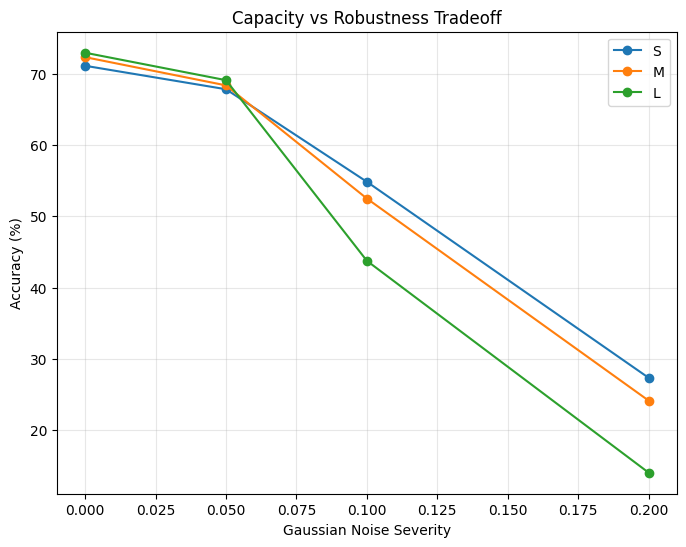

In [ ]:


import matplotlib.pyplot as plt
import numpy as np

noise_levels = [0.0, 0.05, 0.1, 0.2]

plt.figure(figsize=(8,6))

for name in ["S","M","L"]:
    if name not in all_robustness_results:
        print(f"{name} missing!")
        continue
    
    means = []
    for s in noise_levels:
        if s in all_robustness_results[name]:
            means.append(np.mean(all_robustness_results[name][s]))
        else:
            means.append(0)

    print(name, means) 
    plt.plot(noise_levels, means, marker="o", label=name)

plt.xlabel("Gaussian Noise Severity")
plt.ylabel("Accuracy (%)")
plt.title("Capacity vs Robustness Tradeoff")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
print("--- Starting Multi-Seed Rigor Pipeline with Robustness ---")

seeds = [42, 123, 456]
epochs = 5 
batch_size = 64
noise_severities = [0.0, 0.05, 0.1, 0.2] 

all_svd_results = {"S": [], "M": [], "L": []}
all_probe_results = {"S": [], "M": [], "L": []}
all_robustness_results = {"S": {s: [] for s in noise_severities}, 
                          "M": {s: [] for s in noise_severities}, 
                          "L": {s: [] for s in noise_severities}}

def gaussian_noise(x, s):
    return x + torch.randn_like(x) * s

for seed in seeds:
    print(f"\n{'='*50}\n RUNNING SEED: {seed}\n{'='*50}")
    set_seed(seed)
    
    g = torch.Generator()
    g.manual_seed(seed)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True, generator=g)
    
    fresh_models = {
        "S": ScalableStudent(width_factor=1).to(device),
        "M": ScalableStudent(width_factor=2).to(device),
        "L": ScalableStudent(width_factor=4).to(device)
    }
    
    for name, model in fresh_models.items():
        opt = torch.optim.Adam(model.parameters(), lr=1e-3)
        model.train()
        
        # 1. Distillation
        for epoch in range(epochs):
            for img, _ in tqdm(train_loader, desc=f"{name} Ep {epoch+1}", leave=False):
                img = img.to(device)
                with torch.no_grad():
                    z_t = F.normalize(teacher_model.encode_image(img), p=2, dim=-1).to(torch.float32)
                z_s = F.normalize(model(img), p=2, dim=-1).to(torch.float32)
                loss = (1.0 - (z_s * z_t).sum(dim=-1)).mean()
                opt.zero_grad(); loss.backward(); opt.step()
                
        # 2. Centered SVD 
        model.eval()
        embs = []
        with torch.no_grad():
            for img, _ in test_loader:
                embs.append(F.normalize(model(img.to(device)), p=2, dim=-1).cpu())
        
        Z = torch.cat(embs, dim=0).to(torch.float32)
        Z_centered = Z - Z.mean(dim=0, keepdim=True)
        _, S, _ = torch.linalg.svd(Z_centered, full_matrices=False)
        all_svd_results[name].append(S.numpy())
        
        # 3. Locked Linear Probe
        train_embs, train_labs = [], []
        with torch.no_grad():
            for img, lab in train_loader:
                z = F.normalize(model(img.to(device)), p=2, dim=-1)
                train_embs.append(z.cpu().numpy()); train_labs.append(lab.numpy())
        
        probe = LogisticRegression(max_iter=2000, solver='lbfgs', n_jobs=-1)
        probe.fit(np.vstack(train_embs), np.concatenate(train_labs))
        
        base_acc = accuracy_score(y_test, probe.predict(Z.numpy())) * 100
        all_probe_results[name].append(base_acc)
        print(f"   [{name}] Base Probe Acc: {base_acc:.2f}%")
        
        for severity in noise_severities:
            preds = []
            with torch.no_grad():
                for img, _ in test_loader:
                    corrupted = gaussian_noise(img, severity).to(device)
                    z = F.normalize(model(corrupted), p=2, dim=-1)
                    preds.extend(probe.predict(z.cpu().numpy()))
            
            rob_acc = accuracy_score(y_test, preds) * 100
            all_robustness_results[name][severity].append(rob_acc)
            
        torch.cuda.empty_cache()

print("\n=== FINAL 3-SEED AVERAGED ROBUSTNESS ===")
for name in ["S", "M", "L"]:
    print(f"\nModel {name}:")
    for severity in noise_severities:
        mean_acc = np.mean(all_robustness_results[name][severity])
        std_acc = np.std(all_robustness_results[name][severity])
        print(f"  Noise {severity}: {mean_acc:.2f}% ± {std_acc:.2f}%")

--- Starting Multi-Seed Rigor Pipeline with Robustness ---

 RUNNING SEED: 42


   [S] Base Probe Acc: 71.08%


   [M] Base Probe Acc: 72.48%


   [L] Base Probe Acc: 73.21%

 RUNNING SEED: 123


   [S] Base Probe Acc: 70.58%


   [M] Base Probe Acc: 72.84%


   [L] Base Probe Acc: 72.33%

 RUNNING SEED: 456


   [S] Base Probe Acc: 71.66%


   [M] Base Probe Acc: 71.65%


   [L] Base Probe Acc: 73.28%

=== FINAL 3-SEED AVERAGED ROBUSTNESS ===

Model S:
  Noise 0.0: 71.11% ± 0.44%
  Noise 0.05: 67.82% ± 0.74%
  Noise 0.1: 54.84% ± 3.73%
  Noise 0.2: 27.35% ± 5.92%

Model M:
  Noise 0.0: 72.32% ± 0.50%
  Noise 0.05: 68.36% ± 0.60%
  Noise 0.1: 52.49% ± 7.52%
  Noise 0.2: 24.15% ± 6.71%

Model L:
  Noise 0.0: 72.94% ± 0.43%
  Noise 0.05: 69.09% ± 0.38%
  Noise 0.1: 43.76% ± 6.10%
  Noise 0.2: 14.05% ± 1.40%


In [ ]:
print("--- Evaluating Teacher (CLIP ViT-B/32) Robustness ---")

g = torch.Generator()
g.manual_seed(999)
teacher_train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True, generator=g
)

def gaussian_noise(x, s):
    return x + torch.randn_like(x) * s

teacher_train_embs, train_labels = [], []
with torch.no_grad():
    for images, labels in tqdm(teacher_train_loader, desc="Extracting Clean Train Embs"):
        z_t = F.normalize(teacher_model.encode_image(images.to(device)), p=2, dim=-1).cpu().numpy()
        teacher_train_embs.append(z_t)
        train_labels.append(labels.numpy())

print("Fitting Teacher Linear Probe...")
teacher_probe = LogisticRegression(max_iter=2000, solver='lbfgs', n_jobs=-1)
teacher_probe.fit(np.vstack(teacher_train_embs), np.concatenate(train_labels))

noise_levels = [0.0, 0.05, 0.1, 0.2]

print("\n=== TEACHER ROBUSTNESS RESULTS ===")
for s in noise_levels:
    preds = []
    with torch.no_grad():
        for images, _ in test_loader:
            corrupted = gaussian_noise(images, s).to(device)
            z_t_noisy = F.normalize(teacher_model.encode_image(corrupted), p=2, dim=-1).cpu().numpy()
            preds.extend(teacher_probe.predict(z_t_noisy))
    
    acc = accuracy_score(y_test, preds) * 100
    print(f"Teacher Noise {s}: {acc:.2f}%")

--- Evaluating Teacher (CLIP ViT-B/32) Robustness ---


Extracting Clean Train Embs: 100%|██████████| 781/781 [02:13<00:00,  5.86it/s]


Fitting Teacher Linear Probe...

=== TEACHER ROBUSTNESS RESULTS ===
Teacher Noise 0.0: 94.31%
Teacher Noise 0.05: 92.19%
Teacher Noise 0.1: 89.35%
Teacher Noise 0.2: 84.12%


In [ ]:
print("--- The Augmentation Control Experiment (Student-L) ---")

aug_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4),
    torchvision.transforms.RandomHorizontalFlip(),
    clip_preprocess 
])

aug_train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=aug_transform)

g = torch.Generator()
g.manual_seed(42)
aug_train_loader = torch.utils.data.DataLoader(aug_train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True, generator=g)

aug_model = ScalableStudent(width_factor=4).to(device)
opt = torch.optim.Adam(aug_model.parameters(), lr=1e-3)
aug_model.train()

epochs = 5
for epoch in range(epochs):
    for img, _ in tqdm(aug_train_loader, desc=f"Augmented Student-L Ep {epoch+1}", leave=False):
        img = img.to(device)
        with torch.no_grad():
            z_t = F.normalize(teacher_model.encode_image(img), p=2, dim=-1).to(torch.float32)
        z_s = F.normalize(aug_model(img), p=2, dim=-1).to(torch.float32)
        loss = (1.0 - (z_s * z_t).sum(dim=-1)).mean()
        opt.zero_grad(); loss.backward(); opt.step()

aug_model.eval()
train_embs, train_labs = [], []
with torch.no_grad():
    clean_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    for img, lab in clean_train_loader:
        z = F.normalize(aug_model(img.to(device)), p=2, dim=-1).cpu().numpy()
        train_embs.append(z); train_labs.append(lab.numpy())

probe = LogisticRegression(max_iter=2000, solver='lbfgs', n_jobs=-1)
probe.fit(np.vstack(train_embs), np.concatenate(train_labs))

print("\n=== AUGMENTED STUDENT-L ROBUSTNESS ===")
noise_levels = [0.0, 0.05, 0.1, 0.2]
for s in noise_levels:
    preds = []
    with torch.no_grad():
        for img, _ in test_loader:
            corrupted = gaussian_noise(img, s).to(device)
            z = F.normalize(aug_model(corrupted), p=2, dim=-1).cpu().numpy()
            preds.extend(probe.predict(z))
    
    acc = accuracy_score(y_test, preds) * 100
    print(f"Noise {s}: {acc:.2f}%")

--- The Augmentation Control Experiment (Student-L) ---



=== AUGMENTED STUDENT-L ROBUSTNESS ===
Noise 0.0: 69.34%
Noise 0.05: 67.01%
Noise 0.1: 49.49%
Noise 0.2: 14.04%
